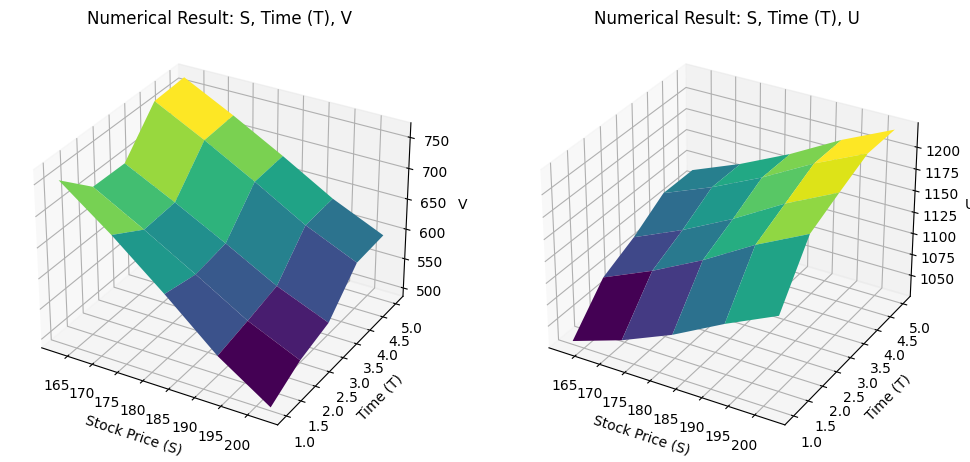

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import scipy.stats as stats
import warnings
import math
import time
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)


def explicit_FD(Pr, C, P, TC, TP, T, sigma, r, d, rc, cv, cp, M, N):
    dx = math.log(400) / M
    dt = T / N
    U_grid = np.zeros((M + 1, N + 1))
    V_grid = np.zeros((M + 1, N + 1))

    cp_period = int(N / (4 * T))
    cp_array = np.arange(cp_period, N + 1, cp_period)
    for i in range(1, M):
        if math.exp(i * dx) >= cv:
            U_grid[i, N] = Pr * math.exp(i * dx) / cv
            V_grid[i, N] = 0
        else:
            U_grid[i, N] = Pr
            V_grid[i, N] = Pr

    for t in range(int(N * TP / T), N):
        U_grid[0, t] = 1050
        U_grid[M, t] = 1900

    for t in range(min(int(N * TP / T), N)):
        U_grid[0, t] = 1050 / (1 + (r + rc) * dt) ** (min(int(N * TP / T), N) - t)
        U_grid[M, t] = 1900 / (1 + (r + rc) * dt) ** (min(int(N * TP / T), N) - t)


    for j in range(N-1,-1,-1):
        for i in range(1,M):
            p1=dt*((sigma**2/2)*(U_grid[i+1,j+1]-2*U_grid[i,j+1]+U_grid[i-1,j+1])/dx**2)
            p2=dt*(r-d-sigma**2/2)*(U_grid[i+1,j+1]-U_grid[i-1,j+1])/(2*dx)
            p3=dt*(-r*(U_grid[i,j+1]-V_grid[i,j+1])-(r+rc)*V_grid[i,j+1])
            aS=(Pr+(j%cp_period)*(Pr*cp/4)/cp_period)*math.exp(i*dx)/cv
            ft=0
            for k in cp_array:
                if j<=k<j+1:
                    ft=Pr*cp/4

            U_grid[i,j]=U_grid[i,j+1]+p1+p2+p3+ft
            H=U_grid[i,j]
            U1=0
            U2=0
            U3=0
            if U_grid[i,j]<aS:
                U1=aS
            if U_grid[i,j]>Pr*C and j>=N*TC/T:
                U2=max(Pr*C,aS)
                H=0
            if U_grid[i,j]<Pr*P and j>=N*TP/T:
                U3=Pr*P
            U_grid[i,j]=max(H,U1,U2,U3)

            if U_grid[i,j]==H:
                q1=dt*((sigma**2/2)*(V_grid[i+1,j+1]-2*V_grid[i,j+1]+V_grid[i-1,j+1])/dx**2)
                q2=dt*(r-d-sigma**2/2)*(V_grid[i+1,j+1]-V_grid[i-1,j+1])/(2*dx)
                q3=dt*(-(r+rc)*V_grid[i,j+1])
                V_grid[i,j]=V_grid[i,j+1]+q1+q2+q3+ft
            elif U_grid[i,j]==aS:
                V_grid[i,j]=0
            elif U_grid[i,j]==Pr*C:
                V_grid[i,j]=Pr*C
            elif U_grid[i,j]==Pr*P:
                V_grid[i,j]=Pr*P

    return U_grid,V_grid


S_values = [162.68, 172.68, 182.68, 192.68, 202.68]
T_values = [1, 2, 3, 4, 5]
results_S_T = []


M1 = 400
N = 5000
for T in T_values:
    U_all, V_all = explicit_FD(1000, 1.1, 1.05, 2, 3, T, 0.3, 0.04, 0.005, 0.02, 200, 0.05, M1, N)
    for S in S_values:
        S_app = int(math.log(S) / (math.log(400) / M1))
        result = [U_all[S_app, 0], V_all[S_app, 0]]
        results_S_T.append({'S': S, 'T': T, 'U': result[0], 'V': result[1]})


df_S_T = pd.DataFrame(results_S_T)
df_S_T.to_csv('Stock_and_time.csv')


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221, projection='3d')


X, Y = np.meshgrid(S_values, T_values)
Z = np.array([item['V'] for item in results_S_T]).reshape(len(T_values), len(S_values))

ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('Stock Price (S)')
ax1.set_ylabel('Time (T)')
ax1.set_zlabel('V')
ax1.set_title('Numerical Result: S, Time (T), V')




ax2 = fig.add_subplot(222, projection='3d')


X, Y = np.meshgrid(S_values, T_values)
Z = np.array([item['U'] for item in results_S_T]).reshape(len(T_values), len(S_values))

ax2.plot_surface(X, Y, Z, cmap='viridis')
ax2.set_xlabel('Stock Price (S)')
ax2.set_ylabel('Time (T)')
ax2.set_zlabel('U')
ax2.set_title('Numerical Result: S, Time (T), U')


plt.show()


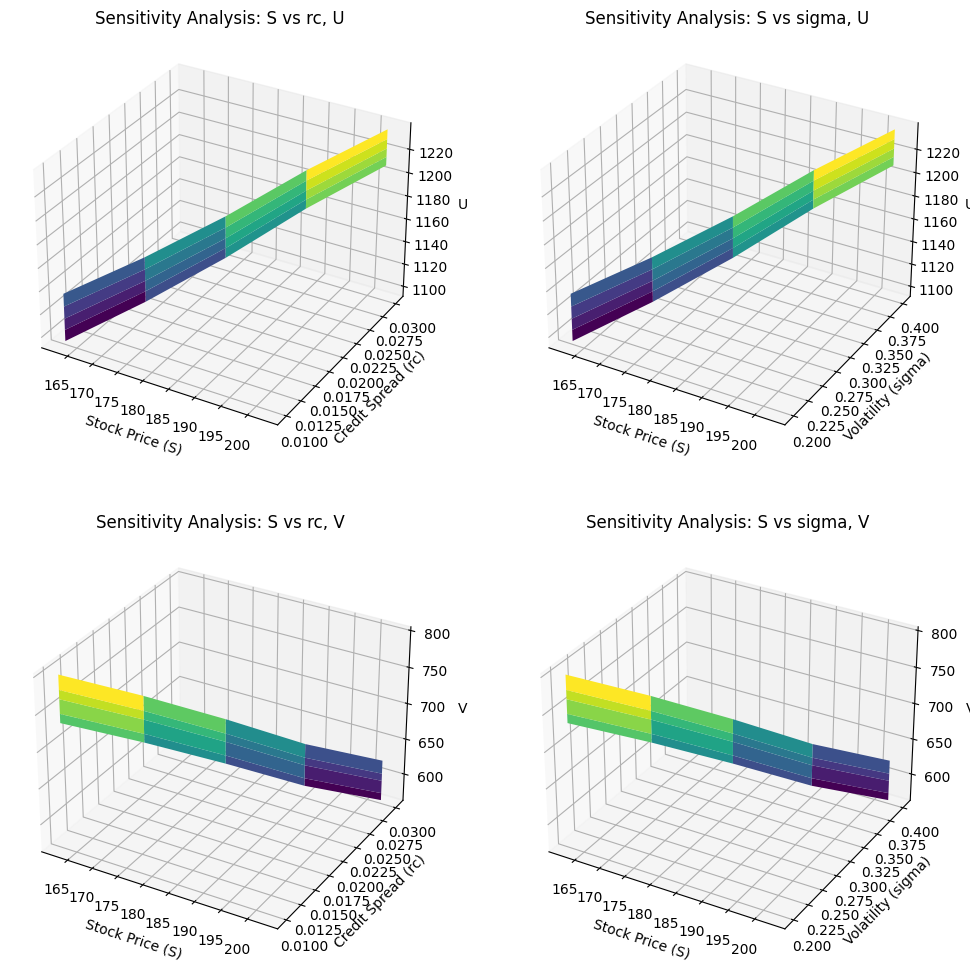

Function execution time: 301.9915232658386 seconds


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import scipy.stats as stats
import warnings
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
def explicit_FD(Pr,C,P,TC,TP,T,sigma,r,d,rc,cv,cp,M,N):
    """
    Pr: principle
    S: stock price
    C:call ratio
    P:put ratio
    TC:call time
    TP:Put time
    T:time
    sigma: volatility
    r: risk-free rate
    d:dividend
    rc:credit spread
    cv:conversion price
    cp=coupon rate
    M:x step
    N:timje step
    """
    dx = math.log(400)/M
    dt = T/N
    U_grid= np.zeros((M+1,N+1))
    V_grid = np.zeros((M+1,N+1))

    cp_period=int(N/(4*T))
    cp_array=np.arange(cp_period,N+1,cp_period)
    for i in range(1,M):
        if math.exp(i*dx) >= cv:
            U_grid[i,N]=Pr*math.exp(i*dx)/cv
            V_grid[i,N]=0
        else:
            U_grid[i,N]=Pr
            V_grid[i,N]=Pr
    for t in range(int(N*TP/T),N):
        U_grid[0,t]=1050
        U_grid[M,t]=1900
    for t in range(int(N*TP/T)):
        U_grid[0,t]=1050/(1+(r+rc)*dt)**(int(N*TP/T)-t)
        U_grid[M,t]=1900/(1+(r+rc)*dt)**(int(N*TP/T)-t)

    for j in range(N-1,-1,-1):
        for i in range(1,M):
            p1=dt*((sigma**2/2)*(U_grid[i+1,j+1]-2*U_grid[i,j+1]+U_grid[i-1,j+1])/dx**2)
            p2=dt*(r-d-sigma**2/2)*(U_grid[i+1,j+1]-U_grid[i-1,j+1])/(2*dx)
            p3=dt*(-r*(U_grid[i,j+1]-V_grid[i,j+1])-(r+rc)*V_grid[i,j+1])
            aS=(Pr+(j%cp_period)*(Pr*cp/4)/cp_period)*math.exp(i*dx)/cv
            ft=0
            for k in cp_array:
                if j<=k<j+1:
                    ft=Pr*cp/4

            U_grid[i,j]=U_grid[i,j+1]+p1+p2+p3+ft
            H=U_grid[i,j]
            U1=0
            U2=0
            U3=0
            if U_grid[i,j]<aS:
                U1=aS
            if U_grid[i,j]>Pr*C and j>=N*TC/T:
                U2=max(Pr*C,aS)
                H=0
            if U_grid[i,j]<Pr*P and j>=N*TP/T:
                U3=Pr*P
            U_grid[i,j]=max(H,U1,U2,U3)

            if U_grid[i,j]==H:
                q1=dt*((sigma**2/2)*(V_grid[i+1,j+1]-2*V_grid[i,j+1]+V_grid[i-1,j+1])/dx**2)
                q2=dt*(r-d-sigma**2/2)*(V_grid[i+1,j+1]-V_grid[i-1,j+1])/(2*dx)
                q3=dt*(-(r+rc)*V_grid[i,j+1])
                V_grid[i,j]=V_grid[i,j+1]+q1+q2+q3+ft
            elif U_grid[i,j]==aS:
                V_grid[i,j]=0
            elif U_grid[i,j]==Pr*C:
                V_grid[i,j]=Pr*C
            elif U_grid[i,j]==Pr*P:
                V_grid[i,j]=Pr*P

    return U_grid,V_grid
start_time = time.time()
S_values = [162.68,172.68,182.68,192.68,202.68]
sigma_values = [0.2,0.25,0.3,0.35,0.4]
rc_values = [0.01,0.015,0.02,0.025,0.03]


results_S_rc = []
results_S_sigma = []
M1=400

for rc in rc_values:
    U_all,V_all = explicit_FD(1000, 1.1, 1.05, 2, 3, 5, 0.3, 0.04, 0.005, rc, 200, 0.05, M1, 5000)
    for S in S_values:
        S_app=int(math.log(S)/(math.log(400)/M1))
        result=[U_all[S_app,0],V_all[S_app,0]]
        results_S_rc.append({'S': S, 'rc': rc, 'U': result[0],'V':result[1]})


for sigma in sigma_values:
    U_all,V_all = explicit_FD(1000, 1.1, 1.05, 2, 3, 5, sigma, 0.04, 0.005, 0.02, 200, 0.05, M1, 5000)
    for S in S_values:
        S_app=int(math.log(S)/(math.log(400)/M1))
        result=[U_all[S_app,0],V_all[S_app,0]]
        results_S_sigma.append({'S': S, 'sigma': sigma, 'U': result[0],'V':result[1]})

df_S_rc = pd.DataFrame(results_S_rc)
df_S_sigma = pd.DataFrame(results_S_sigma)
df_S_rc.to_csv('Stock_and_credit_spread.csv')
df_S_sigma.to_csv('Stock_and_volatility.csv')
fig = plt.figure(figsize=(12, 12))




ax1 = fig.add_subplot(221, projection='3d')
X, Y = df_S_rc['S'][0:5], df_S_rc['rc'][[0,5,10,15,20]]
Z = df_S_rc['U'].values.reshape(5,5)
ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('Stock Price (S)')
ax1.set_ylabel('Credit Spread (rc)')
ax1.set_zlabel('U')
ax1.set_title('Sensitivity Analysis: S vs rc, U')


ax2 = fig.add_subplot(222, projection='3d')
X, Y = df_S_sigma['S'][0:5], df_S_sigma['sigma'][[0,5,10,15,20]]
Z = df_S_rc['U'].values.reshape(5,5)
ax2.plot_surface(X, Y, Z, cmap='viridis')
ax2.set_xlabel('Stock Price (S)')
ax2.set_ylabel('Volatility (sigma)')
ax2.set_zlabel('U')
ax2.set_title('Sensitivity Analysis: S vs sigma, U')


ax3 = fig.add_subplot(223, projection='3d')
X, Y = df_S_rc['S'][0:5], df_S_rc['rc'][[0,5,10,15,20]]
Z = df_S_rc['V'].values.reshape(5,5)
ax3.plot_surface(X, Y, Z,cmap='viridis')
ax3.set_xlabel('Stock Price (S)')
ax3.set_ylabel('Credit Spread (rc)')
ax3.set_zlabel('V')
ax3.set_title('Sensitivity Analysis: S vs rc, V')


ax4 = fig.add_subplot(224, projection='3d')
X, Y = df_S_sigma['S'][0:5], df_S_sigma['sigma'][[0,5,10,15,20]]
Z = df_S_rc['V'].values.reshape(5,5)
ax4.plot_surface(X, Y, Z, cmap='viridis')
ax4.set_xlabel('Stock Price (S)')
ax4.set_ylabel('Volatility (sigma)')
ax4.set_zlabel('V')
ax4.set_title('Sensitivity Analysis: S vs sigma, V')





plt.show()

plt.savefig('plot.png')
plt.close(fig)
end_time=time.time()
elapsed_time=end_time-start_time
print(f"Function execution time: {elapsed_time} seconds")

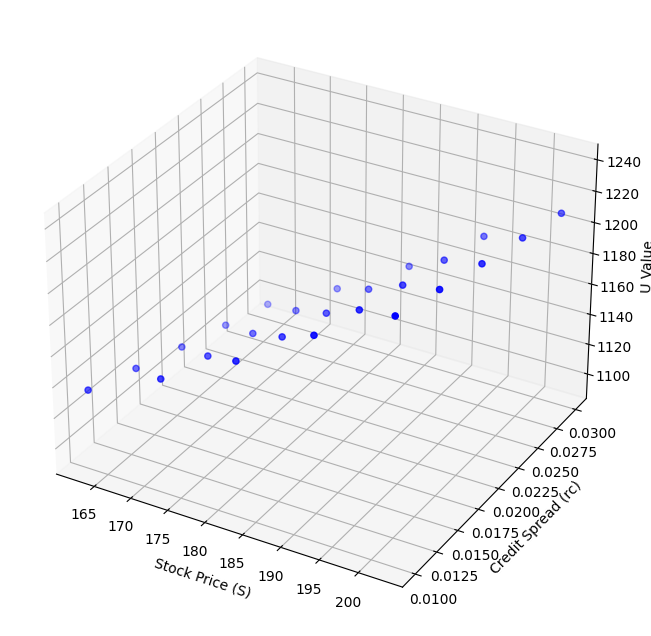

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Assuming the data has been manually extracted from the image and inputted as follows:
data = {
    "S": [
        162.68, 172.68, 182.68, 192.68, 202.68,
        162.68, 172.68, 182.68, 192.68, 202.68,
        162.68, 172.68, 182.68, 192.68, 202.68,
        162.68, 172.68, 182.68, 192.68, 202.68,
        162.68, 172.68, 182.68, 192.68, 202.68
    ],
    "rc": [
        0.01, 0.01, 0.01, 0.01, 0.01,
        0.015, 0.015, 0.015, 0.015, 0.015,
        0.02, 0.02, 0.02, 0.02, 0.02,
        0.025, 0.025, 0.025, 0.025, 0.025,
        0.03, 0.03, 0.03, 0.03, 0.03
    ],
    "U": [
        1135.49593, 1157.38346, 1183.25486, 1213.49645, 1239.25678,
        1124.33448, 1146.95346, 1173.60458, 1204.66169, 1231.04894,
        1113.64289, 1136.94984, 1164.33487, 1196.16083, 1223.14027,
        1103.80872, 1127.79981, 1155.9035, 1188.47168, 1216.01612,
        1093.96329, 1118.61307, 1147.41248, 1180.70325, 1208.80062
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D data
ax.scatter(df['S'], df['rc'], df['U'], c='b', marker='o')

# Set labels
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Credit Spread (rc)')
ax.set_zlabel('U Value')

# Show plot
plt.show()
